In [24]:
import numpy as np
import pandas as pd
#import tensorflow as tf
from matplotlib import pyplot as plt
#import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

16 by 16 matrix

In [25]:
N = 32

In [26]:
data_df = pd.read_csv("data_27GHz_32_N.csv")
input_signals = data_df.iloc[:, :2*N]
output_signals = data_df.iloc[:, 2*N:]

In [27]:
output_signals.shape

(3000, 64)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [29]:
# Custom Layer for Diagonal Matrix
class Layer1(nn.Module):
    def __init__(self, input_size, output_size):
        super(Layer1, self).__init__()
        self.units = output_size
        self.use_bias = True
        #assert input_size == output_size, "Diagonal layers must have input_size == output_size"
        self.weights_D = nn.Parameter(torch.ones(input_size))  # Only store the diagonal elements
        # Initialize trainable weights p=1
        self.F1_1 = nn.Parameter(torch.empty(2, 2))
        self.F1_2 = nn.Parameter(torch.empty(2, 2))
        self.d_dash1 = nn.Parameter(torch.empty(126))

        self.weights_D_2 = nn.Parameter(torch.ones(2*input_size))  # Only store the diagonal elements

        if self.use_bias:
            self.bias = nn.Parameter(torch.empty(self.units))

        # Initialize weights p=1
        nn.init.xavier_normal_(self.F1_1)
        nn.init.xavier_normal_(self.F1_2)
        nn.init.normal_(self.d_dash1, mean=0.0, std=0.01) 
        
        if self.use_bias:
            nn.init.normal_(self.bias, mean=0.0, std=0.01)

    def forward(self, x):
        #Diagonal
        output =  x * self.weights_D  # Element-wise multiplication along the diagonal
        
        # J
        output = torch.concat((output, torch.zeros(x.shape[0], x.shape[1])), dim=1)
        
        def calculateF(out, d_dash, F1, F2):
            # Perform element-wise multiplications
            cal1 = out[:, :out.shape[1] // 2] * d_dash[:out.shape[1] // 2]
            cal2 = out[:, out.shape[1] // 2:] * d_dash[:out.shape[1] // 2]

            # Concatenate intermediate results
            out = torch.cat([
                out[:, :out.shape[1] // 2] + out[:, out.shape[1] // 2:],
                cal1 - cal2
            ], dim=1)

            # Conditional computation based on input dimensions
            if out.shape[1] == 4:
                out = torch.cat([
                    torch.matmul(out[:, :2], F1),
                    torch.matmul(out[:, 2:], F2)
                ], dim=1)
            else:
                out1 = out[:, :out.shape[1] // 2]
                out2 = out[:, out.shape[1] // 2:]
                out = torch.cat([
                    calculateF(out1, d_dash[out.shape[1] // 2:], F1, F2),
                    calculateF(out2, d_dash[out.shape[1] // 2:], F1, F2)
                ], dim=1)

            # Interleave rows for final output
            out = torch.cat([out[:, ::2], out[:, 1::2]], dim=1)
            return out

        # Call the recursive function
        out = calculateF(output, self.d_dash1, self.F1_1, self.F1_2)
    
        output =  out * self.weights_D_2
        # Add bias if applicable
        if self.use_bias:
            out = out + self.bias
            
        return out #torch.concat((out), dim=1)

In [30]:
# Custom Layer for Diagonal Matrix
class Layer2(nn.Module):
    def __init__(self, input_size, output_size):
        super(Layer2, self).__init__()
        self.units = input_size
        self.output_size = output_size
        #assert input_size == output_size, "Diagonal layers must have input_size == output_size"
        self.weights_D = nn.Parameter(torch.ones(output_size))  # Only store the diagonal elements
        self.use_bias = True
        # Initialize trainable weights
        self.F1_1 = nn.Parameter(torch.empty(2, 2))
        self.F1_2 = nn.Parameter(torch.empty(2, 2))
        self.d_dash1 = nn.Parameter(torch.empty(126))

        if self.use_bias:
            self.bias = nn.Parameter(torch.empty(self.output_size))

        # Initialize weights
        nn.init.xavier_normal_(self.F1_1)
        nn.init.xavier_normal_(self.F1_2)
        nn.init.normal_(self.d_dash1, mean=0.0, std=0.01)

        if self.use_bias:
            nn.init.normal_(self.bias, mean=0.0, std=0.01)

    def forward(self, x):
        input1 = x[:, :self.units]
        #Diagonal
        
        def calculateF(out, d_dash, F1, F2):
            # Interleave rows for final output
            out = torch.cat([out[:, ::2], out[:, 1::2]], dim=1)

            # Conditional computation based on input dimensions
            if out.shape[1] == 4:
                out = torch.cat([
                    torch.matmul(out[:, :2], F1),
                    torch.matmul(out[:, 2:], F2)
                ], dim=1)
            else:
                out1 = out[:, :out.shape[1] // 2]
                out2 = out[:, out.shape[1] // 2:]
                out = torch.cat([
                    calculateF(out1, d_dash[out.shape[1] // 2:], F1, F2),
                    calculateF(out2, d_dash[out.shape[1] // 2:], F1, F2)
                ], dim=1)

            # Perform element-wise multiplications
            #cal1 = out[:, :out.shape[1] // 2] * d_dash[:out.shape[1] // 2]
            cal2 = out[:, out.shape[1] // 2:] * d_dash[:out.shape[1] // 2]

            # Concatenate intermediate results
            out = torch.cat([
                out[:, :out.shape[1] // 2] + cal2,
                out[:, :out.shape[1] // 2] - cal2
            ], dim=1)
            
            return out

        # Call the recursive function
        out1 = calculateF(input1, self.d_dash1, self.F1_1, self.F1_2)

        out1 = out1[:, :self.output_size]

        output1 =  out1 * self.weights_D

        # Add bias if applicable
        if self.use_bias:
            out = output1 + self.bias
            
        return out #torch.concat((out), dim=1)

In [31]:
# Parameters
N = 32  # Number of elements
fc = 27e9  # Carrier frequency (27 GHz)
f = 32e9
c = 3e8  # Speed of light
lamb = c / fc  # Wavelength at carrier frequency

l_min = c/f   # Wavelength at max frequency

dx = l_min / 2  # Inter-element spacing

# Compute 16x16 DVM matrix
tau_unit = 2 * dx / (c * N)  # Unit time delay
print(tau_unit)

9.765625e-13


In [32]:
import torch.autograd as autograd

In [33]:
class AlphaLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.delay_units = torch.arange(0, 64)
        # Initialize a trainable parameter for each output neuron
        #self.alpha_raw = nn.Parameter(torch.ones(output_dim) * 10.0)  # Start at 10 (midpoint of 0-20)

    def forward(self, x):
        # Linear transformation
        real_part = x[:, :64]  # First 32 columns
        imag_part = x[:, 64:]  # Last 32 columns

        # Create complex matrix
        complex_matrix = real_part + 1j * imag_part
        
        # Process alphas: clamp to [0, 20] and round using STE
        #alpha_clamped = torch.clamp(self.alpha_raw, 0.0, 49.0)
        #alpha_rounded = STEFunction.apply(alpha_clamped)
        
        delays = torch.exp(-1j * 2 * np.pi * fc * tau_unit*self.delay_units)
        # Multiply each output by its corresponding alpha
        complex_output = complex_matrix * delays  # Element-wise multiplication
        
        #x[:, :32] = complex_output.real
        #x[:, 32:] = complex_output.imag

        # Apply activation
        return torch.concat((complex_output.real, complex_output.imag, x), dim=1)

In [34]:
# Define a custom module for the skip connection
class SkipConnection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dim = input_dim  # The layer to apply (e.g., DelayLayer)
        self.skip_weight = nn.Parameter(torch.ones(input_dim))  # Weight for the skip connection

    def forward(self, x):
        delay_part = x[:, :128]
        previous_x = x[:, 128:]
        
        # Weighted skip connection
        return previous_x + delay_part*self.skip_weight

In [35]:
import torch_levenberg_marquardt as tlm

# Set PyTorch to use high precision for matrix multiplication
torch.set_float32_matmul_precision('high')

# Detect CUDA device for acceleration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [36]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [37]:
# Convert each array to a PyTorch tensor and concatenate them
input_x = torch.tensor(input_signals.to_numpy(), dtype=torch.float32)

# Check the shape of the resulting tensor
print("Input shape:", input_x.shape)

Input shape: torch.Size([3000, 64])


In [38]:
# Convert each array to a PyTorch tensor and concatenate them
output_x = torch.tensor(output_signals.to_numpy(), dtype=torch.float32)

# Check the shape of the resulting tensor
print("Input shape:", output_x.shape)

Input shape: torch.Size([3000, 64])


In [39]:
# %%
# Define a function to create the neural network model
def create_model() -> torch.nn.Module:
    return torch.nn.Sequential(
        nn.Linear(64, 128),
        torch.nn.LeakyReLU(negative_slope=0.1),
        AlphaLayer(128, 64),
        SkipConnection(128, 128),
        nn.Linear(128, 64)
    ).to(device)

In [41]:
# %%
# Define a function to create the neural network model
def create_model() -> torch.nn.Module:
    return torch.nn.Sequential(
        Layer1(64, 128),
        torch.nn.LeakyReLU(negative_slope=0.1),
        AlphaLayer(128, 64),
        SkipConnection(128, 128),
        Layer2(128, 64),
    ).to(device)

In [42]:
import time
import torch
import torch_levenberg_marquardt as tlm
from bokeh.plotting import figure, output_notebook, show
from torch.utils.data import TensorDataset

In [43]:
dataset = TensorDataset(input_x, output_x)

# Split sizes: 80% training, 20% validation
train_size = int(0.8 * len(dataset))  # 80% of 80,000
val_size = len(dataset) - train_size  # Remaining 20%

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create dataset and dataloader
#train_dataset = TensorDataset(input_x, output_x)
train_loader = tlm.utils.FastDataLoader(
    train_dataset,
    batch_size=64,
    repeat=10,
    shuffle=True,
    device=device,
)

val_loader = tlm.utils.FastDataLoader(
    val_dataset,
    batch_size=64,
    repeat=10,
    shuffle=True,
    device=device,
)

In [44]:
# # Example usage
# if __name__ == "__main__":
    # Simulated data for demonstration (replace with your actual data)
    #data = x_t  # Random data: 50,001 samples of (x, y, z)

    # Prepare dataset and dataloader
    #dataloader = prepare_data(input_x, output_x)

model = create_model()

module_lm = tlm.training.LevenbergMarquardtModule(
model=model,
loss_fn=tlm.loss.MSELoss(),
learning_rate=1.0,
attempts_per_step=20,
solve_method='qr',
)

loss_all, val_loss_all = tlm.utils.fit(
module_lm,
train_loader,
epochs=5,
overwrite_progress_bar = False,
val_loader=val_loader,
)

                                                  
Epoch 1/5: 100%|██████████| 380/380 [01:33<00:00,  4.08it/s, loss=2.5791e-03, damping=1.0000e-01, attempts=2]


Epoch 1 complete. Average loss: 2.8184e-01


                                                    
Epoch 2/5: 100%|██████████| 380/380 [01:32<00:00,  4.10it/s, loss=7.6206e-04, damping=1.0000e-01, attempts=3]


Epoch 2 complete. Average loss: 1.7192e-03


                                                    
Epoch 3/5: 100%|██████████| 380/380 [01:37<00:00,  3.89it/s, loss=2.8118e-04, damping=1.0000e-01, attempts=3]


Epoch 3 complete. Average loss: 4.7153e-04


                                                    
Epoch 4/5: 100%|██████████| 380/380 [01:41<00:00,  3.73it/s, loss=1.0163e-04, damping=1.0000e-01, attempts=3]


Epoch 4 complete. Average loss: 1.8664e-04


                                                    
Epoch 5/5: 100%|██████████| 380/380 [01:44<00:00,  3.64it/s, loss=4.1813e-05, damping=1.0000e-02, attempts=1]


Epoch 5 complete. Average loss: 7.4074e-05


In [66]:
# # Plot the loss curve
# loss_all_cpu = [loss_item.cpu().numpy() for loss_item in loss_all]
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(loss_all_cpu) + 1), loss_all_cpu, linestyle="-", color="b")
# plt.title("Training Loss Curve")
# plt.xlabel("Steps")
# plt.ylabel("Loss")
# plt.yscale("log")
# plt.grid(True)
# plt.show()

In [65]:
# # Plot the loss curve
# loss_all_cpu = [loss_item for loss_item in val_loss_all]
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(loss_all_cpu) + 1), loss_all_cpu, linestyle="-", color="b")
# plt.title("Training Loss Curve")
# plt.xlabel("Steps")
# plt.ylabel("Loss")
# plt.yscale("log")
# plt.grid(True)
# plt.show()

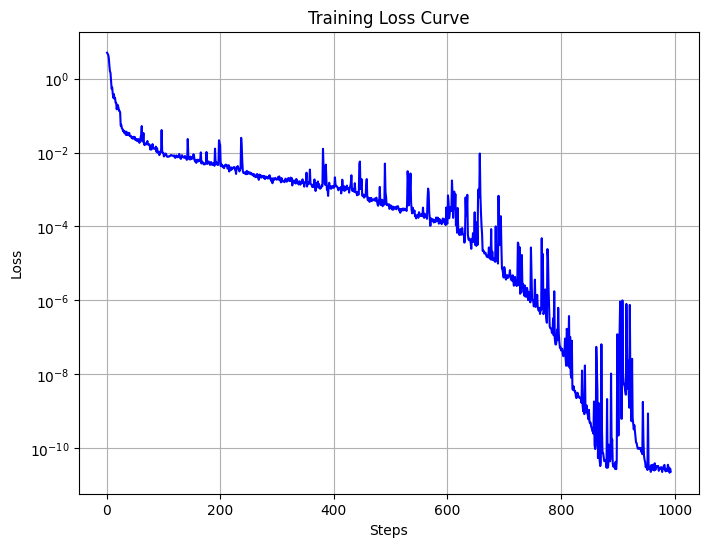

In [60]:
# Assuming loss_all is a list of loss values
loss_all_cpu = [loss_item.cpu().numpy() for loss_item in loss_all]

# Create a DataFrame to store the steps and loss values
data = {
    "Steps": range(1, len(loss_all_cpu) + 1),  # x-axis values
    "Loss": loss_all_cpu  # y-axis values
}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv("training_24_loss_N_8.csv", index=False)

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(df["Steps"], df["Loss"], linestyle="-", color="b")
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True)
plt.show()

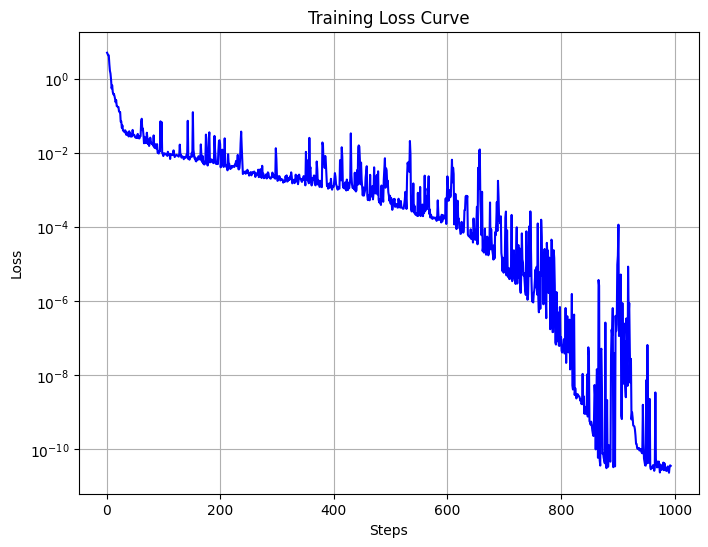

In [61]:
# Assuming loss_all is a list of loss values
loss_all_cpu = [loss_item for loss_item in val_loss_all]

# Create a DataFrame to store the steps and loss values
data = {
    "Steps": range(1, len(loss_all_cpu) + 1),  # x-axis values
    "Loss": loss_all_cpu  # y-axis values
}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv("validation_24_loss_N_8.csv", index=False)

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(df["Steps"], df["Loss"], linestyle="-", color="b")
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True)
plt.show()

In [63]:
df

,Steps,Loss
0,1,5.1
1,2,4.7
2,3,4.3
3,4,4.3
4,5,2.5
...,...,...
988,989,0.0
989,990,0.0
990,991,0.0
991,992,0.0


In [20]:
# Print total number of weights by layer
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:  # Only count trainable parameters
        num_params = param.numel()  # Number of elements in the parameter tensor
        print(f"Layer: {name} | Parameters: {num_params}")
        total_params += num_params

# Print total number of parameters in the model
print(f"\nTotal trainable parameters in the model: {total_params}")

Layer: 0.weight | Parameters: 8192
Layer: 0.bias | Parameters: 128
Layer: 3.skip_weight | Parameters: 128
Layer: 4.weight | Parameters: 8192
Layer: 4.bias | Parameters: 64

Total trainable parameters in the model: 16704


In [21]:
!python --version

Python 3.10.16
